### Importing all the required Libraries

In [1]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin

In [2]:
# Set visualization style
sns.set(style="whitegrid")

In [3]:
class ConstantClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, prediction):
        self.prediction = prediction
    def fit(self, X, y):
        return self
    def predict(self, X):
        return np.full(X.shape[0], self.prediction)
    def predict_proba(self, X):
        # Return 100% probability for the constant class
        if self.prediction == 1:
            return np.column_stack((np.zeros(X.shape[0]), np.ones(X.shape[0])))
        else:
            return np.column_stack((np.ones(X.shape[0]), np.zeros(X.shape[0])))

### Setup & Configurations

In [4]:
# We define which clusters are handled by specific member models vs. constant models.
ACTIVE_CLUSTERS = [0, 1, 5, 6]   # Members provided .joblib files for these
CONSTANT_CLUSTERS = [2, 3, 4]    # These had 0 bankruptcies in training -> Predict 0

# Initializing Generalization Phase
print(f"Expecting models for clusters: {ACTIVE_CLUSTERS}")

Expecting models for clusters: [0, 1, 5, 6]


### Load Data & Team Objects

In [5]:
# Load Test Data
if not os.path.exists('test_data.csv'):
    raise FileNotFoundError("Missing 'test_data.csv' ")

In [6]:
test_df = pd.read_csv('test_data.csv')
submission_index = test_df['Index'] # We need this for the final CSV format
X_test_raw = test_df.drop(columns=['Index'])

In [7]:
print(f"Loaded Test Data: {test_df.shape}")

Loaded Test Data: (1012, 96)


In [8]:
# Loading Team Preprocessing Objects
# These ensure we treat the Test Data exactly like the Training Data.
try:
    team_prep = joblib.load('team_preprocessing.joblib')
    cluster_predictor = joblib.load('team_cluster_predictor.joblib')
    print("Successfully loaded team preprocessing logic and cluster predictor.")
except FileNotFoundError:
    raise FileNotFoundError("Missing team .joblib files.")

Successfully loaded team preprocessing logic and cluster predictor.


### Apply Team Data Preprocessing

In [9]:
selected_features = team_prep['selected_features']
scaler = team_prep['scaler']

In [10]:
# Select the same 50 features used in training
X_test_reduced = X_test_raw[selected_features]
# Scale using the statistics (mean/std) from the training set
X_test_scaled = scaler.transform(X_test_reduced)

### Predict Cluster for Test Data

In [11]:
# We first determine which "Subgroup" each test company belongs to.
test_clusters = cluster_predictor.predict(X_test_reduced)
test_df['Cluster_ID'] = test_clusters

/var/folders/jn/7q4k5xqj6tdc7t0t0_c17hrm0000gn/T/ipykernel_5041/3383381191.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Cluster_ID', data=test_df, palette='tab10')


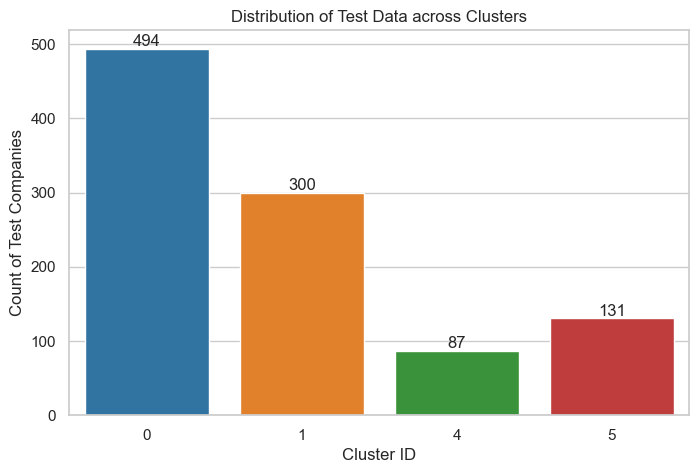

In [12]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Cluster_ID', data=test_df, palette='tab10')
plt.title('Distribution of Test Data across Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Count of Test Companies')
# Add labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

In [13]:
print("\nTest Data Cluster Distribution:")
print(test_df['Cluster_ID'].value_counts().sort_index())


Test Data Cluster Distribution:
Cluster_ID
0    494
1    300
4     87
5    131
Name: count, dtype: int64


### Predict Bankruptcy

In [14]:
final_predictions = []
loaded_models = {}

print("\nLoading Member Models...")
for c_id in ACTIVE_CLUSTERS:
    fname = f'member_model_cluster_{c_id}.joblib'
    if os.path.exists(fname):
        loaded_models[c_id] = joblib.load(fname)
        print(f"  [OK] Loaded {fname}")
    else:
        raise FileNotFoundError(f"MISSING FILE: {fname}. We cannot proceed without this member's work.")

print("\nGenerating Predictions row by row...")
# We iterate through the test set. For each company, we pick the correct expert model.
for idx, row in test_df.iterrows():
    cluster_id = int(row['Cluster_ID'])
    
    if cluster_id in CONSTANT_CLUSTERS:
        # If the cluster was "Safe" (0 bankruptcies) in training, we predict 0.
        pred = 0
        
    elif cluster_id in ACTIVE_CLUSTERS:
        # Load the specialist model for this cluster
        model_bundle = loaded_models[cluster_id]
        
        # 1. Get features (The member might have used specific ones)
        row_features = row[model_bundle['features']].to_frame().T
        
        # 2. Impute & Scale (Using the member's specific scaler)
        row_imputed = model_bundle['imputer'].transform(row_features)
        row_scaled = model_bundle['scaler'].transform(row_imputed)
        
        # 3. Predict Probability
        clf = model_bundle['model']
        
        # Handle the custom ConstantClassifier vs Standard Models
        if isinstance(clf, ConstantClassifier):
             proba = clf.predict_proba(row_scaled)[:, 1][0]
        else:
             proba = clf.predict_proba(row_scaled)[:, 1][0]
            
        # 4. Apply the Tuned Threshold (Crucial for the Sparsity Check)
        threshold = model_bundle['threshold']
        pred = 1 if proba >= threshold else 0
        
    else:
        # Fallback (Should technically never happen)
        pred = 0 
        
    final_predictions.append(pred)


Loading Member Models...
  [OK] Loaded member_model_cluster_0.joblib
  [OK] Loaded member_model_cluster_1.joblib
  [OK] Loaded member_model_cluster_5.joblib
  [OK] Loaded member_model_cluster_6.joblib

Generating Predictions row by row...


### Results & Visualization

In [15]:
submission = pd.DataFrame({
    'Index': submission_index,
    'Bankrupt?': final_predictions
})

In [16]:
positive_count = submission['Bankrupt?'].sum()
total_count = len(submission)
positive_rate = positive_count / total_count

In [17]:
print("\n" + "="*40)
print(f"FINAL STATS")
print("="*40)
print(f"Total Rows:       {total_count}")
print(f"Predicted True:   {positive_count}")
print(f"Positive Rate:    {positive_rate:.2%}")
print("="*40)


FINAL STATS
Total Rows:       1012
Predicted True:   39
Positive Rate:    3.85%


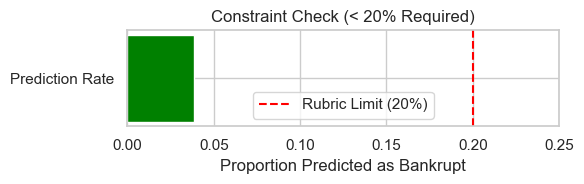

In [18]:
plt.figure(figsize=(6, 2))
plt.barh(['Prediction Rate'], [positive_rate], color='green' if positive_rate < 0.2 else 'red', height=0.5)
plt.axvline(0.20, color='red', linestyle='--', label='Rubric Limit (20%)')
plt.xlim(0, 0.25)
plt.xlabel('Proportion Predicted as Bankrupt')
plt.title('Constraint Check (< 20% Required)')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
if positive_rate >= 0.20:
    print("Constraint is >= 20%.")
else:
    print("Constraint Check Passed (< 20%).")
    
    # Save the file
    filename = '05_Generalization.csv'
    submission.to_csv(filename, index=False)
    print(f"SUCCESS: Saved final submission to '{filename}'")

Constraint Check Passed (< 20%).
SUCCESS: Saved final submission to '05_Generalization.csv'
